# Домашнее задание 3.

`Keras` и сверточные нейронные сети.

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


Using TensorFlow backend.


In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Задание 1 — инициализация весов CNN (3 балла).

В этом задании нужно будет исследовать, как выбор функции инициализации весов влияет на обучение CNN.


Продолжим работать с датасетом CIFAR-10.

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

# нормализуем входные данные
x_train = x_train / 255 - 0.5
x_test = x_test / 255 - 0.5

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 2s 0us/step
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model
from keras.initializers import Zeros, Constant, RandomUniform, glorot_normal, lecun_uniform

Определим функцию `fit_model` с архитектурой архитектура CNN.

Метод `model.fit` возвращает объект класса `keras.callbacks.History()` — это колбэк, который автоматически применяется ко всем моделям и логирует много чего полезного. В частности логируются значения функции потерь на каждой итерации.

**Задание 1.1** (0.5 балла) Добавьте в архитектуру модели инициализацию весов для тех слоев, где она необходима.


In [0]:
def fit_model(initializer='glorot_normal'):
    s = reset_tf_session()  
    INIT_LR = 5e-3
    BATCH_SIZE = 32
    EPOCHS = 10
   
    def lr_scheduler(epoch):
        return INIT_LR * 0.9 ** epoch  

    kernel_initializer = initializer
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3), kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3), kernel_initializer=initializer))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(40, kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10, kernel_initializer=initializer))
    model.add(Activation("softmax"))


    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.adamax(lr=INIT_LR),
        metrics=['accuracy']
    )
  
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],                   
        shuffle=True,
        verbose=0,
        initial_epoch=0    
    )

    # Возвращаем объект класса keras.callbacks.History
    return history

**Задание 1.2** (1.5 балла). Обучите модель с разными [функциями инициализации](https://keras.io/initializers/) весов:
* `Zeros` — веса инициализируются нулями
* `Constant=0.05` — веса инициализируются константой 0.05
* `RandomUniform` — веса генерируются равномерно из отрезка [-0.05, 0.05]
* `glorot_normal` — Xavier initializer из лекций
* `lecun_uniform`

Добавьте в список `losses` значения функции потерь для каждой функции инициализации, их можно достать из `History`



In [6]:
losses = []
losses.append(fit_model(initializer=Zeros()).history['loss'])
losses.append(fit_model(initializer=Constant(value=0.05)).history['loss'])
losses.append(fit_model(initializer=RandomUniform()).history['loss'])
losses.append(fit_model(initializer=glorot_normal()).history['loss'])
losses.append(fit_model(initializer=lecun_uniform()).history['loss'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










**Задание 1.3** (1 балла). Постройте графики зависимости функций потерь от номера итерации, подпишите их. Прокомментируйте результат.

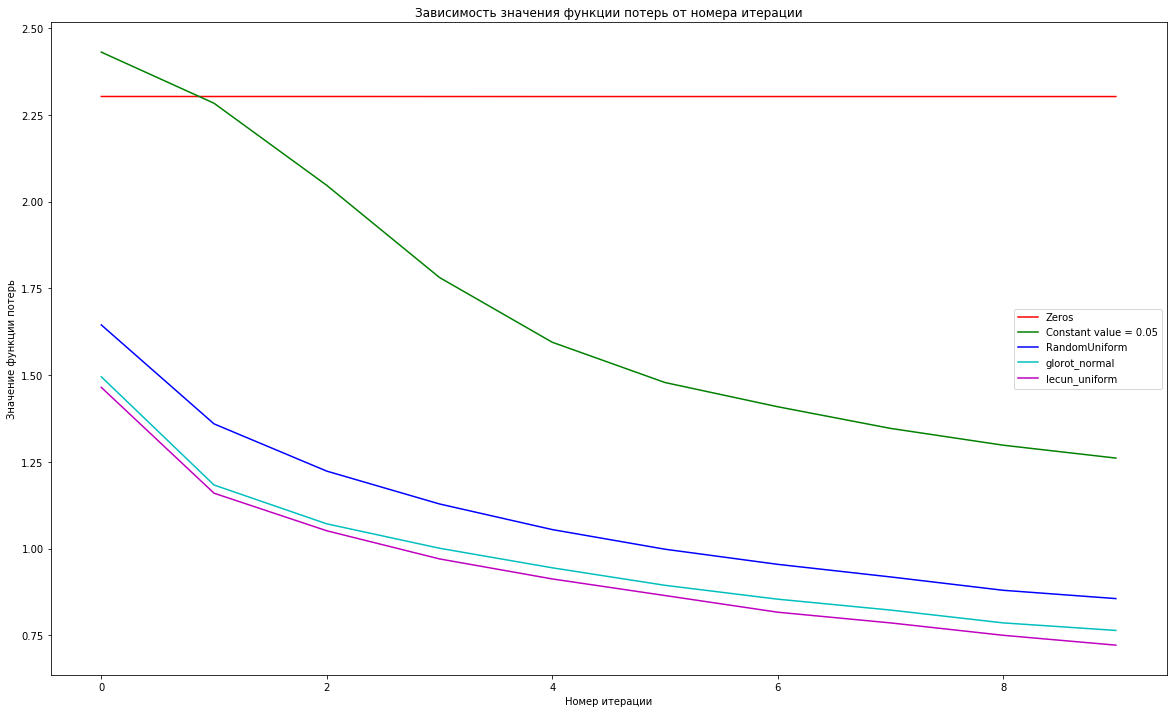

In [7]:
plt.figure(figsize=(20, 12))
plt.plot(losses[0], color="r", label="Zeros")
plt.plot(losses[1], color="g", label="Constant value = 0.05")
plt.plot(losses[2], color="b", label="RandomUniform")
plt.plot(losses[3], color="c", label="glorot_normal")
plt.plot(losses[4], color="m", label="lecun_uniform")
plt.legend(loc="center right")
plt.title("Зависимость значения функции потерь от номера итерации")
plt.xlabel("Номер итерации")
plt.ylabel("Значение функции потерь")

plt.show()

Наилучшей функцией инициализации в данном случае является lecun_uniform, так как для её графика loss минимальный. Это достигается за счёт того, что веса инициализируются из распределения [-limit, limit], где limit = sqrt(3 / fan_in), а fan_in - число входных параметров для тензора весов. Для остальных функций инициализации весов значения loss хуже (выше). Худшей функцией для kernel_initializer является Zeros(). При инициализации всех весов нулями, нейроны скрытого слоя получат на вход одинаковый результат - произведение Wi,j * X, где Wi,j = 0. При инициализации с помощью функции Zeros() это будут нули. Функция активации также будет браться от нуля, loss не меняется.

## Задание 2 — CNN для CIFAR-10 с сохранением весов модели (7 баллов)

В этом задании мы модифицируем нейросеть с семинара, чтобы она достигала большего значения `accuracy` и научимся сохранять веса модели в файл во время обучения. Можно использовать только те же слои, которые использовались на семинаре: `Conv2D, MaxPooling2D,  LeakyReLU, Dropout, Flatten, Dense`.

**Задание 2.1** (4 балла). Подберите архитектуру модели так, чтобы значение `accuracy` на тестовой выборке было не менее 85.

In [0]:
def make_model():    
    model = Sequential()
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3), input_shape=(32,32,3), kernel_initializer='lecun_uniform'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=128, padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer='lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(256))                
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10))             
    model.add(Activation("softmax"))

    return model

In [0]:
INIT_LR = 5e-3  # стартовый learning rate
BATCH_SIZE = 32
EPOCHS = 20

s = reset_tf_session()

model = make_model()


model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# формула, по которой будет меняться learning rate в зависимости от эпохи, передадим ее в LearningRateScheduler callback
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# будем выводить актуальный learning rate в начале каждой итерации (on_epoch_begin)
# для этого нужно написать кастомный callback
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [11]:
# обучаем модель
model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(),],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0    
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
Learning rate: 0.005
50000/50000 [==============================] - 67s 1ms/step - loss: 1.4823 - acc: 0.4565 - val_loss: 0.9785 - val_acc: 0.6587
Epoch 2/20
Learning rate: 0.0045
50000/50000 [==============================] - 66s 1ms/step - loss: 0.9070 - acc: 0.6871 - val_loss: 0.7457 - val_acc: 0.7457
Epoch 3/20
Learning rate: 0.00405
50000/50000 [==============================] - 66s 1ms/step - loss: 0.6976 - acc: 0.7607 - val_loss: 0.6489 - val_acc: 0.7827
Epoch 4/20
Learning rate: 0.003645
50000/50000 [==============================] - 66s 1ms/step - loss: 0.5603 - acc: 0.8103 - val_loss: 0.5773 - val_acc: 0.8090
Epoch 5/20
Learning rate: 0.0032805
50000/50000 [==============================] - 66s 1ms/step - loss: 0.4586 - acc: 0.8446 - val_loss: 0.5278 - val_acc: 0.8261
Epoch 6/20
Learning rate: 0.00295245
50000/50000 [==============================] - 66s 1ms/step - loss: 0.3593 - acc: 0.8768 - val_loss: 0.5137 - val

**Задание 2.2** (2 балла). Реализуйте колбэк, который сохраняет модель в `.hdf5` файл и печатает имя файла, в который была сохранена модель. Используйте функцию `model_save`. Строка с именем файла имеет вид `<name>_{0:02d}.hdf5`, отформатируйте ее так, чтобы в имени строки фигурировал номер эпохи.

In [0]:
from keras.models import save_model, load_model

class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        filename = self.file_name.format(epoch+1)
        save_model(model, filename)
        print('Model saved to ' + filename)

**Задание 2.3** (1 балл). Реализуйте функцию, которая с помощью `load_model` будет загружать модель из файла.

In [0]:
def load_from_file(model_filename, last_epoch):
  model = load_model(model_filename.format(last_epoch))
  return model

In [14]:
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 20

model_filename = 'weights_{0:02d}.hdf5'

s = reset_tf_session()

model = make_model()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=INIT_LR),
    metrics=['accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch 

# в случае, если обучение было прервано, можно загрузить модель из файла, 
# соответствующего последней эпохе, за которую есть сохраненные веса
# model = load_from_file(model_filename, 4)
  
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               ModelSaveCallback(model_filename)
              ],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0    
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 66s 1ms/step - loss: 1.4814 - acc: 0.4593 - val_loss: 0.9941 - val_acc: 0.6507
Model saved to weights_01.hdf5
Epoch 2/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.9010 - acc: 0.6876 - val_loss: 0.7359 - val_acc: 0.7477
Model saved to weights_02.hdf5
Epoch 3/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.6939 - acc: 0.7620 - val_loss: 0.6171 - val_acc: 0.7951
Model saved to weights_03.hdf5
Epoch 4/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.5649 - acc: 0.8068 - val_loss: 0.5693 - val_acc: 0.8072
Model saved to weights_04.hdf5
Epoch 5/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.4601 - acc: 0.8427 - val_loss: 0.5150 - val_acc: 0.8316
Model saved to weights_05.hdf5
Epoch 6/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.3619 - acc: 0.8755 - val_loss

In [15]:
model2 = load_from_file(model_filename, 4)

history = model2.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               ModelSaveCallback(model_filename)
              ],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0    
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.5728 - acc: 0.8056 - val_loss: 0.6426 - val_acc: 0.7881
Model saved to weights_01.hdf5
Epoch 2/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.4946 - acc: 0.8330 - val_loss: 0.5468 - val_acc: 0.8241
Model saved to weights_02.hdf5
Epoch 3/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.4093 - acc: 0.8615 - val_loss: 0.5455 - val_acc: 0.8320
Model saved to weights_03.hdf5
Epoch 4/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.3312 - acc: 0.8871 - val_loss: 0.5413 - val_acc: 0.8305
Model saved to weights_04.hdf5
Epoch 5/20
50000/50000 [==============================] - 67s 1ms/step - loss: 0.2681 - acc: 0.9095 - val_loss: 0.5689 - val_acc: 0.8469
Model saved to weights_05.hdf5
Epoch 6/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.2103 - acc: 0.9282 - val_loss